In [3]:
import os
import pickle
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.svm import SVC

Define method for grid search with different classification methods

In [15]:
def perform_logistic_regression(X, y):
    # Grid search with logistic regression
    lr = LogisticRegression(C=1.0)

    # GridSearch for liblinear solver
    C_range = [0.1, 1, 10, 100, 1000, 10000]
    penalty_options = ['l1', 'l2']
    fit_intercept_options = [True, False]
    solver_option = ['liblinear']
    class_weight_option = ['auto', '']

    param_grid = dict(C=C_range, penalty=penalty_options, fit_intercept=fit_intercept_options, solver=solver_option)

    # solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
    # multi_class_options = ['ovr', 'multinomial']
    # class_weight_options = [None, 'balanced']

    # param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options)

    perform_grid_search(lr, X, y, param_grid, "Logistic Regression")


def perform_lda(X, y):
    lda = LinearDiscriminantAnalysis()

    solver_options = ['lsqr']
    #shrinkage_options = [None, 'auto']
    shrinkage = np.arange(0.0, 1.05, 0.05)
    
    param_grid = dict(solver=solver_options, shrinkage=shrinkage)

    perform_grid_search(lda, X, y, param_grid, "LDA")
    

def perform_grid_search(clf, X, y, param_grid, name):
    
    cv = StratifiedKFold(n_splits=10)
    
    grid_clf = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
    grid_clf.fit(X, y)

    print("# Tuning parameters for %s" % name)
    print()
    # best results
    print("The best parameters are %s with a score of %0.2f" \
          % (grid_clf.best_params_, grid_clf.best_score_))
    print()
    # complete results
    # means = grid_clf.cv_results_['mean_test_score']
    # stds = grid_clf.cv_results_['std_test_score']
    # for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
    #     print("%0.3f (+/-%0.03f) for %r"
    #           % (mean, std * 2, params))
    # print("\n")


In [5]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FCz', 'FC6', 'T7', 'C3', 'Cz', 'C4',
            'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

Set important directories.

In [6]:
working_directory = 'L:/int_err2'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))

Load separability indices.

In [8]:
std_comp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_comp_corr.pkl'))
with open(std_comp_corr_file, 'rb') as pickle_file:
    std_comp_corr = pickle.load(pickle_file)
    
std_incomp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_incomp_corr.pkl'))
with open(std_incomp_corr_file, 'rb') as pickle_file:
    std_incomp_corr = pickle.load(pickle_file)

In [44]:
std_comp_corr.extract_features([[100, 160]], CHANNELS, 'Consc_Group')
std_incomp_corr.extract_features([[100, 160], [200, 240]], CHANNELS, 'Consc_Group')

X_std_comp, y_std_comp = std_comp_corr.get_features_and_labels('Consc_Group')
X_std_incomp, y_std_incomp = std_incomp_corr.get_features_and_labels('Consc_Group')

In [42]:
perform_lda(X_std_comp, y_std_comp)
perform_lda(X_std_incomp, y_std_incomp)
perform_logistic_regression(X_std_comp, y_std_comp)
perform_logistic_regression(X_std_incomp, y_std_incomp)

# Tuning parameters for LDA

The best parameters are {'shrinkage': 0.1, 'solver': 'lsqr'} with a score of 0.69

# Tuning parameters for LDA

The best parameters are {'shrinkage': 0.9, 'solver': 'lsqr'} with a score of 0.65

# Tuning parameters for Logistic Regression

The best parameters are {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'} with a score of 0.67

# Tuning parameters for Logistic Regression

The best parameters are {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'} with a score of 0.63



In [32]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X_std_comp, y_std_comp, test_size=0.1, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Best parameters set found on development set:

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.656 (+/-0.157) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.260 (+/-0.013) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.701 (+/-0.153) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.681 (+/-0.107) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.612 (+/-0.179) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.735 (+/-0.078) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.587 (+/-0.200) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.598 (+/-0.152) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.571 (+/-0.231) for {'C': 1, 'kernel': 'linear'}
0.552 (+/-0.236) for {'C': 10, 'kernel': 'linear'}
0.552 (+/-0.236) for {'C': 100, 'kernel': 'linear'}
0.552 (+/-0.236) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

In [27]:
def run_evaluation(clf, X, y):
    
    results = []
    
    for iteration in range(0, 10):
        
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=iteration)

        # Variable for accuracy score
        mean_accuracy = 0
        
        for train, test in cv.split(X, y):
            
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])

            # Compute accuracy score
            y_pred = clf.fit(X[train], y[train]).predict(X[test])
            
            mean_accuracy += accuracy_score(y[test], y_pred)
            

        # Mean accuracy
        mean_accuracy /= 10
        
        results.append(mean_accuracy)
            
    return results

In [55]:
### Evaluation of classification with STD incomp

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.9)
lr = LogisticRegression(C=0.1, fit_intercept=True, penalty='l1', solver='liblinear')

results_lda = run_evaluation(lda, X_std_incomp, y_std_incomp)
results_lr = run_evaluation(lr, X_std_incomp, y_std_incomp)

results_std_incomp = []
results_std_incomp.append(results_lda)
results_std_incomp.append(results_lr)

In [56]:
print(results_std_incomp)

[[0.5999999999999999, 0.6366666666666666, 0.59, 0.5766666666666667, 0.6166666666666668, 0.55, 0.61, 0.6533333333333333, 0.6066666666666666, 0.5700000000000001], [0.6333333333333332, 0.5999999999999999, 0.5999999999999999, 0.58, 0.6466666666666667, 0.5366666666666667, 0.5933333333333334, 0.6033333333333333, 0.5733333333333333, 0.5433333333333332]]


In [57]:
### Evaluation of classification with STD comp

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.35)
lr = LogisticRegression(C=0.1, fit_intercept=True, penalty='l1', solver='liblinear')

results_lda = run_evaluation(lda, X_std_comp, y_std_comp)
results_lr = run_evaluation(lr, X_std_comp, y_std_comp)

results_std_comp = []
results_std_comp.append(results_lda)
results_std_comp.append(results_lr)

In [58]:
print(results_std_comp)

[[0.69, 0.6933333333333332, 0.7066666666666666, 0.6733333333333333, 0.6533333333333333, 0.6699999999999999, 0.6066666666666667, 0.6866666666666666, 0.6866666666666666, 0.7], [0.5966666666666666, 0.6166666666666666, 0.6666666666666666, 0.6533333333333332, 0.6466666666666667, 0.6566666666666667, 0.6466666666666667, 0.6533333333333333, 0.6799999999999999, 0.6499999999999999]]


Collect all evaluation results:

[0.67666667 0.64666667]
[0.601 0.591]
[0.0275681  0.02260777]
[0.02940333 0.03296631]
(2, 2)


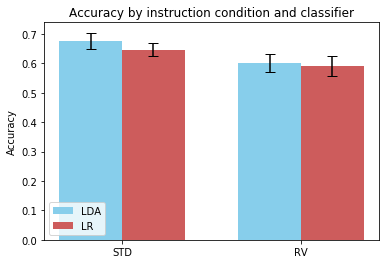

In [59]:
results_std_comp = np.array(results_std_comp)
results_std_incomp = np.array(results_std_incomp)

results = []
print(np.mean(results_std_comp, axis=1))
print(np.mean(results_std_incomp, axis=1))

print(np.std(results_std_comp, axis=1))
print(np.std(results_std_incomp, axis=1))

results.append(results_std_comp)
results.append(results_std_incomp)

results = np.array(results)

means = np.mean(results, axis=2)
stds = np.std(results, axis=2)

print(means.shape)

ind = np.arange(len(means))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, means[:,0], width, yerr=stds[:,0], color='SkyBlue', label='LDA', capsize=5)
rects2 = ax.bar(ind + width/2, means[:,1], width, yerr=stds[:,1], color='IndianRed', label='LR', capsize=5)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by instruction condition and classifier')
ax.set_xticks(ind)
ax.set_xticklabels(('STD', 'RV', 'RR'))
ax.legend()

plot_path = os.path.abspath(os.path.join(image_directory, 'interr1_comparison_lr_lda.png'))

plt.savefig(plot_path, dpi=300, bbox_inches='tight')
